# Test of GraphSAGE
- the version of 1 layer graphSAGE
- use DGL
- predict `graphs`
- valid, test data are in the training dataset

In [1]:
import os
import dgl
import json
import torch
import torch as th
import dgl.nn as dglnn
# from tqdm import tqdm
from tqdm.notebook import tqdm  # 使用 notebook 版本的 tqdm
import torch.nn as nn
from dgl.nn import GraphConv, GATConv, SAGEConv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

- check the GPU and assign the GPU by the best memory usage

In [2]:
import subprocess
import torch

def get_free_gpu():
    try:
        # Run nvidia-smi command to get GPU details
        _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
        command = "nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader"
        memory_free_info = _output_to_list(subprocess.check_output(command.split())) 
        memory_free_values = [int(x) for i, x in enumerate(memory_free_info)]
        
        # Get the GPU with the maximum free memory
        best_gpu_id = memory_free_values.index(max(memory_free_values))
        return best_gpu_id
    except:
        # If any exception occurs, default to GPU 0 (this handles cases where nvidia-smi isn't installed)
        return 0

if torch.cuda.is_available():
    # Get the best GPU ID based on free memory and set it
    best_gpu_id = get_free_gpu()
    device = torch.device(f"cuda:{best_gpu_id}")
else:
    device = torch.device("cpu")
    print("there's no available GPU")

# device = torch.device(f"cuda:{1}")
print(device)


cuda:3


## Fix the seed

In [3]:
import numpy as np
import torch
import random

#fix seed
def same_seeds(seed = 8787):
    torch.manual_seed(seed)
    # random.seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Data Loader

In [4]:
class GraphDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        return data

def collate(samples):
    data_list = samples
    batched_graphs = []
    for data in data_list:
        g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

        g.ndata['feat'] = th.tensor(data["node_feat"])
        g.edata['feat'] = th.tensor(data["edge_attr"])
        g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

        batched_graphs.append(g)
    
    return dgl.batch(batched_graphs)

In [5]:
datasets = ['train', 'valid', 'test']
# datasets = ['valid']
dataset_data = {}

for dataset_name in tqdm(datasets):
    file_path = f"../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/{dataset_name}.jsonl"
    
    print(file_path)
    with open(file_path) as f:
        data_list = [json.loads(line) for line in tqdm(f, position=0, leave=True)]
    
    dataset_data[dataset_name] = GraphDataset(data_list, device)

print("Datasets loaded!")

  0%|          | 0/3 [00:00<?, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/train.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/valid.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/test.jsonl


0it [00:00, ?it/s]

Datasets loaded!


- choose batch size

In [6]:
def create_dataloaders(batch_size, shuffle=True):
    dataloaders = {}
    for dataset_name, dataset in dataset_data.items():
        # do not shuffle the testing dataset
        if dataset_name == "test":
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)    
        else:
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    return dataloaders

dataloaders = create_dataloaders(16)

- Turn the print message to a log file

In [7]:
import datetime

now = datetime.datetime.now()

formatted_time = now.strftime("%m%d_%H:%M")

log_file_path = f"../log_message/{formatted_time}_GraphSAGE_transR_50.log"

def add_log_msg(msg, log_file_path=log_file_path):
    with open(log_file_path, 'a') as f:
        f.write(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}\n')
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}')

print(log_file_path)

../log_message/1011_22:48_GraphSAGE_transR_50.log


### Model

In [8]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GraphSAGE, self).__init__()
        self.layer1 = dglnn.SAGEConv(in_dim, out_dim, 'pool')
#         self.layer2 = dglnn.SAGEConv(hidden_dim, out_dim, 'pool')
        self.dropout = nn.Dropout(0.25)

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = torch.relu(h)
#         h = self.dropout(h)
#         h = self.layer2(g, h)
        return h

In [9]:
class MLPPredictor(nn.Module):
    def __init__(self, out_feats, out_classes):
        super().__init__()
        self.W = nn.Linear(out_feats*2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [14]:
class Model(nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super().__init__()
        self.sage = GraphSAGE(in_features, out_features)
        self.pred = MLPPredictor(out_features, num_classes)
      
    def forward(self, g, node_feat, return_logits=False):
        h = self.sage(g, node_feat)
        logits = self.pred(g, h)
        
        return logits

- Model Forward  

In [15]:
def model_fn(batched_g, model, criterion, device, count=1, which_type='train'):
    """Forward a batch through the model."""
#     batched_g, labels = data
    batched_g = batched_g.to(device)
    
    labels = batched_g.edata['label'].to(device)
    
    logits = model(batched_g, batched_g.ndata['feat'].float())

    loss = criterion(logits, labels)

    output = torch.softmax(logits, dim=1)
    preds = output.argmax(1)
    
    # Compute accuracy
    accuracy = torch.mean((preds == labels).float())
    
    if which_type == 'validation' and count % 1000 == 0:
        add_log_msg(f"labels of Validation: {labels} {labels.shape}")
        add_log_msg(f"predicted of Validation: {preds} {preds.shape}")
        
    elif which_type == 'test'  and count % 1000 == 0:
        add_log_msg(f"labels of Test: {labels} {labels.shape}")
        add_log_msg(f"predicted of Test: {preds} {preds.shape}")
        
    if count % 5000 == 0: 
        add_log_msg(f"labels of {count}: {labels} {labels.shape}")
        add_log_msg(f"predicted of {count}: {preds} {preds.shape}")
        
    return loss, accuracy, preds

### Training

- Fix the seed and save the model.state_dict that contains the initial weight

In [16]:
seed = 8787
same_seeds(seed)

model = Model(in_features=50, out_features=128, num_classes=167)
torch.save(model.state_dict(), 'model3_initial(graphsage)/initial_weight.pth')

In [17]:
# model.layer1.fc_self.weight
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.1415, -0.1232, -0.2210,  ..., -0.1132,  0.1040,  0.1068],
        [ 0.2094, -0.0312,  0.1230,  ..., -0.0153, -0.0057,  0.1573],
        [-0.1400,  0.2284, -0.0143,  ..., -0.1863, -0.2516, -0.1591],
        ...,
        [ 0.1911,  0.0178, -0.2430,  ..., -0.1795, -0.0926, -0.0837],
        [ 0.1862,  0.0516,  0.0851,  ...,  0.2165,  0.2184, -0.2323],
        [ 0.0705, -0.0225,  0.0456,  ..., -0.0348, -0.0728,  0.2025]],
       requires_grad=True)

- Check if model really load the model_dict

In [18]:
model = Model(in_features=50, out_features=128, num_classes=167)
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.1415, -0.1232, -0.2210,  ..., -0.1132,  0.1040,  0.1068],
        [ 0.2094, -0.0312,  0.1230,  ..., -0.0153, -0.0057,  0.1573],
        [-0.1400,  0.2284, -0.0143,  ..., -0.1863, -0.2516, -0.1591],
        ...,
        [ 0.1911,  0.0178, -0.2430,  ..., -0.1795, -0.0926, -0.0837],
        [ 0.1862,  0.0516,  0.0851,  ...,  0.2165,  0.2184, -0.2323],
        [ 0.0705, -0.0225,  0.0456,  ..., -0.0348, -0.0728,  0.2025]],
       requires_grad=True)

In [20]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from torch.optim import AdamW, lr_scheduler

seed = 5269
same_seeds(seed)

# model = GraphSAGE(in_dim=50, hidden_dim=16, out_dim=167)
model = Model(in_features=50, out_features=128, num_classes=167)
# in_dim means the dimension of the node_feat(50 dim, since the 50-dim embedding)
# out_dim means the # of the categories -> 168 for out tasks
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
best_model_path = "../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-7.pt"

model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=18, num_training_steps=total_steps)

# T_max control the period of the lr changing -> set 1/10 first
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0, last_epoch=- 1, verbose=False)

criterion = nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

total_steps = 50

# save the best model
best_val_loss = float('inf')
patience = 10  # Number of epochs with no improvement after which training will be stopped.
waiting = 0  # The number of epochs with no improvement so far.


# Training Part
for epoch in tqdm(range(total_steps)):
    # Train
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0
    
    for batched_g in tqdm(dataloaders['train'], desc="Training", position=0, leave=True):
        num_batches += 1
        loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='train')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

    scheduler.step()
    add_log_msg(f"total batches: {num_batches}")

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    add_log_msg(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_accuracy:.4f}')

    
    # Validation Part
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0
    num_batches = 0


    with torch.no_grad():
        for batched_g in tqdm(dataloaders['valid'], desc="Validation", position=0, leave=True):
            loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='validation')
            total_accuracy += accuracy.item()
            total_loss += loss.item()
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    current_loss = total_loss / num_batches
    
    add_log_msg(f'Validation Loss: {current_loss:.4f} | Validation Accuracy: {avg_accuracy:.4f}\n')
    
            
    if current_loss < best_val_loss:
        best_val_loss = current_loss
        waiting = 0
        
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            add_log_msg("Find a better model!!")

        torch.save(model.state_dict(), best_model_path)

#         print(best_model_path)

    else:
        waiting += 1
        if waiting >= patience:
            add_log_msg("============================== Early stopping ==================================")
            break

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 22:51:39# labels of 5000: tensor([  7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,  68,  68,  97,
        108, 108, 108, 108,  35,  35,  35,  35,  35,  35, 146, 146, 146, 146,
        146, 146,  26,  26,  26,  26,  26,  26, 119, 112,  65,  65,  65,  65,
         65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,   5,   5,   5,
        133, 133, 133, 133, 133, 133, 133, 133,  91,  91,  91,  19,  19,  19,
         19,  19, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 22:52:18# labels of Validation: tensor([ 92,  99,  99,  99,  99,  99,  99,  99,  99,  99,  65,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  45,  65,  45,  45,
         45,  45,  45,  83,  73,  73,  73, 153, 153, 153,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  58,  58,  58,  58,  58,  58,  58,  91,  91,  91, 133, 133,
        133, 133, 133, 133, 133, 133,  94,  94, 129, 129, 129, 129, 129, 129,
        129, 126, 12

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 22:53:27# labels of 5000: tensor([ 86,  86,  76,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  84,  84,  84,
         84,  84,  84,  84,  84,  84, 164, 148, 148, 148, 148, 148, 148, 148,
        108, 108, 108, 108,  34, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134,  65, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,  58,  58,
         58,  58,  58,  58,  58,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 22:54:05# labels of Validation: tensor([ 48,  86,  86, 163,  65, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 151, 153, 153, 153, 103, 103,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7, 160, 160, 160, 160, 160,
        160, 160, 160, 130, 130, 130, 130, 130,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3, 121, 163, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,  65,  65,  65,
         65,  65,  6

10/11/2023, 22:54:14# Validation Loss: 0.2842 | Validation Accuracy: 0.9337

10/11/2023, 22:54:14# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 22:55:10# labels of 5000: tensor([ 26,  26,  26,  26,  26,  26,  81,  95,  95,  95, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  21,  21,  21,  21,
         21,  21,  21,  21,  21,  21,  21, 150, 146, 146, 146, 146, 146, 146,
         60,  96,  96,  96,  96,  96,  96,  48,  26,  26,  26,  26,  26,  26,
         11, 133, 133, 133, 133, 133, 133, 133, 133,  90,  90,  85,  85,  85,
         85,  85,  85,  85,  85,  85,  85,  85], device='cuda:3') torch.Size([92])
10/11/2023, 22:55:10# predicted of 5000: tensor([ 26,  26,  26,  26,  26,  26,  59,  95,  95,  95, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  21,  21,  21,  21,
         21,  21,  21,  21,  21,  21,  21,  93, 146, 146, 146, 146, 146, 146,
         68,  96,  96,  96,  96,  96,  96,  68,  26,  26, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 22:55:46# labels of Validation: tensor([ 83, 119,  87,  14, 114, 114,  96,  96,  96,  96,  96,  96,  94,  94,
        139, 139, 139, 139, 139, 129, 129, 129, 129, 129, 129, 129, 138, 138,
        138, 138, 138, 138, 138, 138, 138, 138,  65,  65,  65, 102, 102, 107,
        107, 107, 107, 107, 107, 107, 107,  69,  69,  69,  69,  69,  69, 117,
        117, 117,  44, 146, 146, 146, 146, 146, 146], device='cuda:3') torch.Size([65])
10/11/2023, 22:55:46# predicted of Validation: tensor([131,  91,  91,  91,  95,  95,  96,  96,  96,  96,  96,  96,  94,  94,
        139, 139, 139, 139, 139, 129, 129, 129, 129, 129, 129, 129, 138, 138,
        138, 138, 138, 138, 138, 138, 138, 138,  65,  65,  65, 102, 102, 107,
        107, 107, 107, 107, 107, 107, 107,  69,  69,  69,  69,  69,  69, 117,
        117, 117, 131, 146, 146, 146, 146, 146, 146], device='cuda:3') torch.Size([65])
10/11/2023, 22:55:46# labels of 0: tensor([ 83, 119,  87,  14, 114, 114,  96,  96,  96,  96,  96,  96,  94,  

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 22:56:54# labels of 5000: tensor([114, 114,  61,  61,  61,  57,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  13,  13,
         13,  13,  13,  75,  35,  35,  65,  35,  35,  35,  35, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128,  30, 103, 103, 111, 122, 122, 122, 122, 122, 122, 122,
        108, 108, 108, 108,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  28,  28,  28,  28,  28,  65,  28,  28,  28,
         28,  28,  28,  28,  72,  72], device='cuda:3') torch.Size([104])
10/11/2023, 22:56:54# predicted of 5000: tensor([ 91,  91,  61,  61,  61,  91,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  13,  13,
         13,  13,  13,  91,  35,  35,  65,  35,  35,  35,  35, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 22:57:34# labels of Validation: tensor([136, 136, 136, 136, 136, 136, 136, 100, 100, 100, 100, 100, 100, 112,
         66,  66,  66,  66,  66,  66,  66,  66,  66,  66, 163,  91,  91,  91,
         39,  39,  39,  33,  38, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 22:58:40# labels of 5000: tensor([155,  65,  65, 155, 155, 155,  64,  64, 163, 115, 115, 115, 115, 115,
        115, 115, 115, 115, 115, 137, 137, 137, 137, 137,  44, 129, 129, 129,
        129, 129, 129, 129,  92,  71,  71,  71,  71,  71,  71,  29,  29,  29,
         29,  29,  29,  29,  29,  29,  29,  19,  19,  19,  19,  19, 114, 114,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17, 144, 117, 117, 117,  17,  17,  17,  17,
         17,  17,  17,  17

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 22:59:14# labels of Validation: tensor([ 69,  69,  69,  69,  69,  69,  48,  55,  69,  69,  69,  69,  69,  69,
         74,  20,  20,  18,  26,  26,  26,  26,  26,  26, 116,  80,  80,  80,
         80,  80,  80, 136, 136, 136, 136, 136, 136, 136, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 110, 110,
         80,  80,  80,  80,  80,  80,  40,  40,  40,  40,  40,  40,  40,  40,
         40,  40,  40,  40], device='cuda:3') torch.Size([74])
10/11/2023, 22:59:14# predicted of Validation: tensor([ 69,  69,  69,  69,  69,  69,  91, 131,  69,  69,  69,  69,  69,  69,
        131,  20,  20,   8,  26,  26,  26,  26,  26,  26, 131,  80,  80,  80,
         80,  80,  80, 136, 136, 136, 136, 136, 136, 136, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 119, 119,
         80,  80,  80,  80,  80,  80,  40,  40,  40,  40,  40,  40,  40,  40,
         40,  40,  40,  40], device='cuda:3') torch.Size([74])
10/

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:00:24# labels of 5000: tensor([ 49,   8,   8,   9, 104, 140, 140, 140, 140, 140, 140, 140, 140, 140,
        140, 140, 140, 140,  56,  56,  56,  56,  56,  56, 115, 115, 115, 115,
        115, 115, 115, 115, 115, 115,  65,  65,  65,  65,  65, 135, 135,  31,
        148, 148, 148, 148, 148, 148, 148,  49, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:00:57# labels of Validation: tensor([152, 160, 160, 160, 160, 160, 160, 160, 160,  80,  80,  80,  80,  80,
         80,  36,  98,  27,  27,  27,  87, 116, 114, 114,  48, 109, 155, 155,
        155, 155,  44, 157,  67,  67,  67,  67,  67,  43,  43],
       device='cuda:3') torch.Size([39])
10/11/2023, 23:00:57# predicted of Validation: tensor([131, 160, 160, 160, 160, 160, 160, 160, 160,  80,  80,  80,  80,  80,
         80, 131,  98,  27,  27,  27, 131, 131,  17,  17, 119,  94, 155, 155,
        155, 155,  88,   8,  78,  78,  78,  78,  78,  43,  43],
       device='cuda:3') torch.Size([39])
10/11/2023, 23:00:57# labels of 0: tensor([152, 160, 160, 160, 160, 160, 160, 160, 160,  80,  80,  80,  80,  80,
         80,  36,  98,  27,  27,  27,  87, 116, 114, 114,  48, 109, 155, 155,
        155, 155,  44, 157,  67,  67,  67,  67,  67,  43,  43],
       device='cuda:3') torch.Size([39])
10/11/2023, 23:00:57# predicted of 0: tensor([131, 160, 160, 160, 160, 160, 160, 160, 160, 

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:02:00# labels of 5000: tensor([ 89,  89,  90,  90,  72,  72,  12,  77,  77,  77,  77,  77,  77,  77,
         77, 104, 131, 131, 131, 131, 131, 114, 114,  67,  67,  67,  67,  67,
         45,  65,  45,  45,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17, 151,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  20,  20,  84,  84,
         84,  84,  84,  84

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:02:39# labels of Validation: tensor([159, 159, 159,  ...,   0,  44, 121], device='cuda:3') torch.Size([2214])
10/11/2023, 23:02:39# predicted of Validation: tensor([159, 159, 159,  ...,   0, 108, 131], device='cuda:3') torch.Size([2214])
10/11/2023, 23:02:39# labels of 0: tensor([159, 159, 159,  ...,   0,  44, 121], device='cuda:3') torch.Size([2214])
10/11/2023, 23:02:39# predicted of 0: tensor([159, 159, 159,  ...,   0, 108, 131], device='cuda:3') torch.Size([2214])
10/11/2023, 23:02:48# labels of Validation: tensor([152,  59,  59,  59,  63,  63,  63,  63,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140,
        140, 117, 117, 117, 160, 160, 160, 160, 160, 160, 160, 160,  14, 158,


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:03:44# labels of 5000: tensor([111,  24, 100, 100, 100, 100, 100, 100,  51,  65,  65,  51,  51,  51,
         51,   1,  91,  91,  91,  12,  94,  94,  97,  35,  35,  35,  35,  35,
         35, 144,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:04:22# labels of Validation: tensor([ 93,  93,  62,  62,  62,  62,  62,  62,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65, 141, 141, 141, 141, 141, 141, 141,
        141, 141, 141,   4,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  95,  95,
         95,  27,  27,  27,  10,  10, 166, 166, 166, 166, 166, 166,  89,  89,
         36,  33,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66, 131, 131,
        131, 131, 13

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:05:26# labels of 5000: tensor([152,  81, 143, 108, 108, 108, 108, 117, 117, 117,  41,  41,  41,  41,
         41,  89,  89, 104, 163,  67,  67,  67,  67,  67,   2,  54,  66,  66,
         66,  66,  66,  66,  66,  66,  66,  66, 125,  92,  60],
       device='cuda:3') torch.Size([39])
10/11/2023, 23:05:26# predicted of 5000: tensor([  8,  88,  11, 108, 108, 108, 108, 117, 117, 117,  41,  41,  41,  41,
         41,  89,  89, 108, 108,  78,  78,  78,  78,  78, 108,  88,  66,  66,
         66,  66,  66,  66,  66,  66,  66,  66,  72, 108,   8],
       device='cuda:3') torch.Size([39])
10/11/2023, 23:06:07# total batches: 8250
10/11/2023, 23:06:07# Epoch 8 | Train Loss: 0.2551 | Train Accuracy: 0.9370


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:06:07# labels of Validation: tensor([ 65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 143,  47,  47,  93,  93,  51,  51,  51,
         51,  51,  65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 153, 153, 153,  27,  27,  27,  34,
         38,  31,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 135, 135,
        158,  79,  79, 157], device='cuda:3') torch.Size([88])
10/11/2023, 23:06:07# predicted of Validation: tensor([ 65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149,  74,  68,  88, 131, 131,  51,  51,  51,
         51,  51,  65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 153, 153, 153,  27,  27

10/11/2023, 23:06:17# Validation Loss: 0.2502 | Validation Accuracy: 0.9376

10/11/2023, 23:06:17# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:07:17# labels of 5000: tensor([ 27,  27,  27, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134,  65, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 130, 130, 130, 130,
        130, 145, 145, 145, 145, 145, 145,  65, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149,  54,   9, 138, 138,
        138, 138, 138, 138, 138, 138, 138, 138,  45,  65,  45,  45, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
         56,  56,  56,  56,  56,  56, 144,  49,  83, 138, 138, 138, 138, 138,
        138, 138, 138, 138, 138, 113, 113], device='cuda:3') torch.Size([147])
10/11/2023, 23:07:17# predicted of 5000: tensor([ 27,  27,  27, 134, 134, 134, 134, 134, 134, 134, 134,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:07:57# labels of Validation: tensor([  1, 142, 126, 126, 126, 107, 107, 107, 107, 107, 107, 107, 107,  18,
        166, 166, 166, 166, 166, 166, 103, 103,  55,  13,  13,  13,  13,  13,
        139, 139, 139, 139, 139, 151,  51,  51,  51,  51,  51,  61,  61,  61,
         19,  19,  19,  19,  19, 139, 139, 139, 139, 139, 136, 136, 136, 136,
        136, 136, 136], device='cuda:3') torch.Size([59])
10/11/2023, 23:07:57# predicted of Validation: tensor([ 93,  72, 126, 126, 126, 107, 107, 107, 107, 107, 107, 107, 107,   8,
        166, 166, 166, 166, 166, 166,  59,  59, 119,  13,  13,  13,  13,  13,
        139, 139, 139, 139, 139,   9,  51,  51,  51,  51,  51,  61,  61,  61,
         19,  19,  19,  19,  19, 139, 139, 139, 139, 139, 136, 136, 136, 136,
        136, 136, 136], device='cuda:3') torch.Size([59])
10/11/2023, 23:07:57# labels of 0: tensor([  1, 142, 126, 126, 126, 107, 107, 107, 107, 107, 107, 107, 107,  18,
        166, 166, 166, 166, 166, 166, 103, 103,  55,  13

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:09:06# labels of 5000: tensor([105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,  86,
         86, 109, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 133, 133, 133, 133, 133, 133,
        133, 133,  65, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123,  19,  19,  19,  19,  19,  85,  85,  85,  85,  85,
         85,  85,  85,  85,  85,  85,  26,  26,  26,  26,  26,  26, 164, 109,
         97, 151,  34, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 155,  65,  65,  65,  65,
         65,  65, 155, 155, 155], device='cuda:3') torch.Size([159])
10/11/2023, 23:09:06# predicted of 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:09:41# labels of Validation: tensor([ 29,  29,  29,  29,  29,  29,  29,  29,  29,  29,  18,  26,  26,  26,
         26,  26,  26,  20,  20,  30,  79,  79, 144, 125, 162,  23,  23,  23,
         23,  23,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3, 126, 126, 126,  96,  96,  96,  96,  96,  96,  13,  13,
         13,  13,  13, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:10:44# labels of 5000: tensor([133, 133, 133, 133, 133, 133, 133, 133,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82, 145, 145, 145, 145, 145, 145,   8,
          8, 114, 114,  39,  39,  39, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156,  65,  65,  65,  65,  65,  65, 156, 156,
        156, 156, 156, 156, 156, 156,   5,   5,   5,  65, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 107, 107, 107,
        107, 107, 107, 107, 107,   1, 151,  38,  65,  65, 102, 102,  34,  83],
       device='cuda:3') torch.Size([154])
10/11/2023, 23:10:44# predicted of 5000: tensor([133, 133, 13

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:11:19# labels of Validation: tensor([ 36,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17, 137, 137, 137, 137, 137,  51,  51,
         51,  51,  51,  61,  61,  61,  62,  62,  62,  62,  62,  62,   1,  64,
         64,  81,  88,  88,  96,  96,  96,  96,  96,  96, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,  62,  62,
         62,  62,  62,  62,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  1

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:12:24# labels of 5000: tensor([ 26,  26,  26,  26,  26,  26,  98, 122, 122, 122, 122, 122, 122, 122,
         64,  64, 116, 100, 100, 100, 100, 100, 100,  83,  69,  69,  69,  69,
         69,  69,  39,  39,  39, 142,  77,  77,  77,  77,  77,  77,  77,  77,
        145, 145, 145, 145, 145, 145,  96,  96,  96,  96,  96,  96, 119,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,
         48], device='cuda:3') torch.Size([99])
10/11/2023, 23:12:24# predicted of 5000: tensor([ 26,  26,  26,  26,  26,  26,  98, 122, 122, 122, 122, 122, 122, 122,
        108, 108,  87, 100, 100, 100, 100, 100, 100, 125,  69,  69,  69,  69,
         69,  69,  39,  39,  39,  90,  77,  77,  77,  77,  77,  77,  77,  77,
        145, 145, 145, 145, 145, 145,  96,  96,  96,  96,  96,  96, 125,  65,
         65,  6

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:13:00# labels of Validation: tensor([  7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  65,  82,  82,  82,  82,  82,  82,  82,  82,  82,  18,  13,  13,
         13,  13,  13, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 16

10/11/2023, 23:13:10# Validation Loss: 0.2411 | Validation Accuracy: 0.9371

10/11/2023, 23:13:10# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:14:04# labels of 5000: tensor([ 59,  59,  59, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127,  87, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:14:42# labels of Validation: tensor([139, 139, 139, 139, 139,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25, 163,
         75, 164,  15,  15,  15,  12,  12,  79,  79,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  50,  50,  50, 151,  33,  61,
         61,  61,  63,  63,  63,  63, 119], device='cuda:3') torch.Size([105])
10/11/2023, 23:14:42# predicted of Validation: tensor([139, 139, 139, 139, 139,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  2

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:15:53# labels of 5000: tensor([120, 120, 120, 120, 120, 120, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156,  65,  65,  65,  65,  65,  65,  65, 156,
        156, 156, 156, 156, 156, 156, 156,  51,  65,  65,  65,  51,  51,  51,
         51,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  75, 100,
        100, 100, 100, 100, 100, 107, 107, 107, 107, 107, 107, 107, 107, 146,
        146, 146, 146, 146, 146,  98, 150, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:16:31# labels of Validation: tensor([ 17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  48, 107, 107, 107, 107, 107, 107, 107,
        107, 129, 129, 129, 129, 129, 129, 129,  15,  15,  15,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99, 147,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65, 147, 147, 147, 147, 103, 103,  40,  40,  40,  40,  40,
         40, 129, 12

10/11/2023, 23:16:41# Validation Loss: 0.2366 | Validation Accuracy: 0.9395

10/11/2023, 23:16:41# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:17:41# labels of 5000: tensor([125,  38,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29, 158,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  65,  82,  82,  82,  82,  82,  82,  82,  82,  82,  60,
        121,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3, 119,  12, 121,  79,  79, 100, 100, 100, 100, 100, 100,  89,
         89,  81,  19,  19,  19,  19,  19], device='cuda:3') torch.Size([77])
10/11/2023, 23:17:41# predicted of 5000: tensor([ 72,  79,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29,  87,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  65,  82,  82,  82,  82,  82,  82,  82,  82,  82,  87,
        109,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,  76,  87, 110,  84,  79, 100, 100, 100, 100, 100, 100,  89,
         89,  87,  19,  19,  19,  19,  19], device='cuda:3') to

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:18:17# labels of Validation: tensor([ 31,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 141, 141, 141,
        141, 141, 141, 141, 141, 141, 141,  65, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123,  81,  84,  84,  84,  84,
         84,  84,  84,  84,  84,  77,  77,  77,  77,  77,  77,  77,  77,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 10

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:19:21# labels of 5000: tensor([108, 108, 108, 108,  64,  64,   5,   5,   5, 139, 139, 139, 139, 139,
         40,  40,  40,  40,  40,  40,  21,  21,  21,  21,  21,  21,  21,  21,
         21,  21,  21,  37,  37,  37,  37,  37, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  65,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99, 152,  31,  41,  41,  41,  41,  41,  66,  66,  66,  66,  66,
         66,  66,  66,  66,  66,  86,  86, 158,  34], device='cuda:3') torch.Size([93])
10/11/2023, 23:19:21# predicted of 5000: tensor([131, 131, 131, 131,  64,  64,   5,   5,   5, 139, 139, 139, 139, 139,
         40,  40,  40,  40,  40,  40,  21,  21,  21,  21,  21,  21,  21,  21,
         21,  21,  21,  37,  37,  37,  37,  37, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  65,  99,  99,  99,  99,  99,  99, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:19:55# labels of Validation: tensor([ 63,  63,  63,  63, 155,  65,  65,  65,  65,  65,  65, 155, 155, 155,
         33,  60,  89,  89,  71,  71,  71,  71,  71,  71,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 23:20:03# labels of Validation: tensor([  1,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149,  61,  61,  61,  59,  59,  59, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140, 140,  92, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118,  51,  65,  51,  51,  51,  51,  63,  63,  63,  63,
        136, 136, 136, 136, 136, 136, 136,  11, 107, 107, 107, 107, 107, 107,
        107, 107,  67,  67,  67,  67,  67,  33, 109,  59,  59,  59],
       device='cuda:3') torch.Size([110])
10/11/2023, 23:20:03# predicted of Validation: tensor([ 88,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149,  61,  61,  61,  59,  59,  59, 140, 140, 140,
        140, 140, 

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:20:57# labels of 5000: tensor([163,  90,  90,  15,  15,  15,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52, 166, 166, 166, 166, 166, 166,  94,  94,   4, 146, 146,
        146, 146, 146, 146, 120, 120, 120, 120, 120, 120,  73,  73,  73,  87,
         39,  39,  39, 109

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:21:33# labels of Validation: tensor([104,  33,  45,  ..., 122, 122, 122], device='cuda:3') torch.Size([1700])
10/11/2023, 23:21:33# predicted of Validation: tensor([ 64,   9,  45,  ..., 122, 122, 122], device='cuda:3') torch.Size([1700])
10/11/2023, 23:21:33# labels of 0: tensor([104,  33,  45,  ..., 122, 122, 122], device='cuda:3') torch.Size([1700])
10/11/2023, 23:21:33# predicted of 0: tensor([ 64,   9,  45,  ..., 122, 122, 122], device='cuda:3') torch.Size([1700])
10/11/2023, 23:21:41# labels of Validation: tensor([152,  72,  72,  94,  94,  58,  58,  58,  58,  58,  58,  58,  66,  66,
         66,  66,  66,  66,  66,  66,  66,  66,  96,  96,  96,  96,  96,  96,
        126, 126, 126, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105,  64,  64,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85,
         85, 155,  65,  65,  65,  65,  65,  65, 155, 155, 155, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105, 105, 105,  35,  35,  65,  35,


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:22:41# labels of 5000: tensor([ 92,  63,  63,  63,  63, 114, 114, 108, 108, 108, 108, 120, 120, 120,
        120, 120, 120, 107, 107, 107, 107, 107, 107, 107, 107, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165,  20,  20, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,  65,
         65, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:23:20# labels of Validation: tensor([ 45,  65,  45,  ..., 134, 134, 151], device='cuda:3') torch.Size([1983])
10/11/2023, 23:23:20# predicted of Validation: tensor([ 45,  65,  45,  ..., 134, 134,  57], device='cuda:3') torch.Size([1983])
10/11/2023, 23:23:20# labels of 0: tensor([ 45,  65,  45,  ..., 134, 134, 151], device='cuda:3') torch.Size([1983])
10/11/2023, 23:23:20# predicted of 0: tensor([ 45,  65,  45,  ..., 134, 134,  57], device='cuda:3') torch.Size([1983])
10/11/2023, 23:23:28# labels of Validation: tensor([164, 103, 103,  35,  35,  35,  35,  35,  35,  65,  65,  65,  65,  65,
         65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:24:23# labels of 5000: tensor([  5,   5,   5, 121,  58,  58,  58,  58,  58,  58,  58,  44,   4,  49,
         83,  48, 163, 146, 146, 146, 146, 146, 146,  97,   9,   8,   8,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
         39,  39,  39, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101], device='cuda:3') torch.Size([75])
10/11/2023, 23:24:23# predicted of 5000: tensor([  5,   5,   5,  88,  58,  58,  58,  58,  58,  58,  58,  88,  88, 142,
         88, 142,  88, 146, 146, 146, 146, 146, 146,  54, 131,  88,  88,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
         39,  39,  39, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101], device='cuda:3') torch.Size([75])
10/11

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:24:56# labels of Validation: tensor([ 81,   1,  36,   4, 111, 108, 108, 108, 108,  71,  71,  71,  71,  71,
         71, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123,  41,  41,  41,  41,  41,   9, 153, 153, 153, 111,  31,  59,
         59,  59, 164,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3], device='cuda:3') torch.Size([60])
10/11/2023, 23:24:56# predicted of Validation: tensor([114, 114, 143, 143, 143, 108, 108, 108, 108,  71,  71,  71,  71,  71,
         71, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123,  41,  41,  41,  41,  41, 143, 153, 153, 153, 143, 143, 108,
        108, 108, 114,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3], device='cuda:3') torch.Size([60])
10/11/2023, 23:24:56# labels of 0: tensor([ 81,   1,  36,   4, 111, 108, 108, 108, 108,  71,  71,  71,  71,  71,
         71, 123, 123, 123, 123, 123, 123, 123

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:25:59# labels of 5000: tensor([  1, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,  74,  98,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:26:33# labels of Validation: tensor([ 65,  46,  46, 163, 116, 137, 137, 137, 137, 137,  86,  86,  72,  72,
        136, 136, 136, 136, 136, 136, 136, 126, 126, 126, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,  92,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

10/11/2023, 23:26:42# labels of Validation: tensor([ 47, 117, 117, 117,  11,   5,   5,   5, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156,  65, 156, 156, 156, 156, 156,
        156, 156, 156, 120, 120, 120, 120, 120, 120, 112,  81,  75,  88,  88,
        120, 120, 120, 120, 120, 120,   9,  21,  21,  21,  21,  21,  21,  21,
         21,  21,  21,  21, 152,   2, 133, 133, 133, 133, 133, 133, 133, 133],
       device='cuda:3') torch.Size([112])
10/11/2023, 23:26:42# predicted of Validation: tensor([ 18, 117, 117, 117, 119,   5,   5,   5, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:27:41# labels of 5000: tensor([  4,  49,  30, 139, 139, 139, 139, 139,  75,  65,  65, 102, 102,  94,
         94, 133, 133, 133, 133, 133, 133, 133, 133, 129, 129, 129, 129, 129,
        129, 129,  64,  64,  61,  61,  61, 139, 139, 139, 139, 139,  54,  68,
         68, 142, 119], device='cuda:3') torch.Size([45])
10/11/2023, 23:27:41# predicted of 5000: tensor([ 47,  42, 119, 139, 139, 139, 139, 139,  68,  65,  65, 102, 102,  94,
         94, 133, 133, 133, 133, 133, 133, 133, 133, 129, 129, 129, 129, 129,
        129, 129,  91,  91,  61,  61,  61, 139, 139, 139, 139, 139, 110,  91,
         91,  64,  42], device='cuda:3') torch.Size([45])
10/11/2023, 23:28:20# total batches: 8250
10/11/2023, 23:28:20# Epoch 21 | Train Loss: 0.2363 | Train Accuracy: 0.9392


Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:28:20# labels of Validation: tensor([134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134,  44,  71,  71,  71,  71,  71,  71,  26,
         26,  26,  26,  26,  26, 148, 148, 148, 148, 148, 148, 148, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 23:28:30# Validation Loss: 0.2318 | Validation Accuracy: 0.9400

10/11/2023, 23:28:30# Find a better model!!


Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:29:30# labels of 5000: tensor([ 51,  65,  51,  51,  51,  51,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,  89,  89,  55,  81, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:30:06# labels of Validation: tensor([ 93,  93, 122, 122, 122, 122, 122, 122, 122, 166, 166, 166, 166, 166,
        166,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  65,  82,  82,  82,  82,  82,  82,  82,  82,
         82, 119,  37,  37,  37,  37,  37, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 23:30:15# labels of Validation: tensor([163, 100, 100, 100, 100, 100, 100,  19,  19,  19,  19,  19,  49,  59,
         59,  59,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  88,  88,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:31:13# labels of 5000: tensor([114, 114,   9,  91,  91,  91,  67,  67,  67,  67,  67, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70, 133, 133, 133,
        133, 133, 133, 133, 133,  71,  71,  71,  71,  71,  71, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:31:52# labels of Validation: tensor([ 37,  37,  37,  37,  37, 113, 113, 147, 147, 147, 147, 147,  42,   9,
        152, 144,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  12,  91,  91,  91, 117, 117, 117, 112,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 23:32:02# labels of Validation: tensor([ 58,  58,  58,  58,  58,  58,  58, 104, 150,  73,  73,  73,  34,  48,
        153, 153, 153, 131, 131, 131, 131, 131,  40,  40,  40,  40,  40,  40,
         64,  64,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16, 108, 108, 108, 108,  72,  72,
        137, 137, 137, 137, 137,  67,  67,  67,  67,  67,  79,  79],
       device='cuda:3') torch.Size([68])
10/11/2023, 23:32:02# predicted of Validation: tensor([ 58,  58,  58,  58,  58,  58,  58, 119,   4,  73,  73,  73,  93,  55,
        153, 153, 153, 131, 131, 131, 131, 131,  40,  40,  40,  40,  40,  40,
        108, 131,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16, 108, 108, 108, 108,  72,  72,
        137, 137, 137, 137, 137,  67,  67,  67,  67,  67,  79,  79],
       device='cuda:3') torch.Size([68])
10/11/2023, 23:32:02# Validation Loss: 0.2326 | Validation Accura

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:32:56# labels of 5000: tensor([104,   8,   8, 166, 166, 166, 166, 166, 166,  48,  76,  26,  26,  26,
         26,  26,  26, 114, 114, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,   8,   8,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127,   0,   0,   0,   0,   0,   0,  49,
         11, 163,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85],
       device='cuda:3') torch.Size([97])
10/11/2023, 23:32:56# predicted of 5000: tensor([ 59,  59,  59, 166, 166, 166, 166, 166, 166,  92,  36,  26,  26,  26,
         26,  26,  26,  91,  91, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,  59,  59,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3, 127, 127, 127

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:33:30# labels of Validation: tensor([156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
         65,  65, 156, 156, 156, 156, 156, 156, 156, 156,  11, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/11/2023, 23:33:39# labels of Validation: tensor([124, 147,  65,  65,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147,
        147,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  65,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  62,  62,  62,  62,  62,  62,  60,  49,   8,   8,  35,  35,  35,
         35,  35,  35,  44,  36, 166, 166, 166, 166, 166, 166, 114, 114,  72,
         72,   2, 163, 146, 146, 146, 146, 146, 146], device='cuda:3') torch.Size([79])
10/11/2023, 23:33:39# predicted of Validation: tensor([108, 147,  65,  65,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147,
        147,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  65,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  62,  62,  62,  62,  62,  62,  30,  68, 113, 113,  35,  35,  35,
         35,  35,  35, 164,  92, 166, 166, 166, 166, 166, 166, 103, 103,  72,
         72, 164,  68, 146, 146, 146, 146

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:34:38# labels of 5000: tensor([  4,  84,  84,  84,  84,  84,  84,  84,  84,  84,   0,   0,   0,   0,
          0,   0, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118,  51,  65,  65,  65,  51,
         51,  51,  51, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156,  65,  65,  65, 156, 156, 156, 156, 156, 156, 156, 156,
        144, 137, 137, 137, 137, 137, 145, 145, 145, 145, 145, 145, 146, 146,
        146, 146, 146, 146, 150,  10,  10,  24,  21,  21,  21,  21,  21,  21,
         21,  21,  21,  21,  21,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  37,  37,  37,
         37,  37], device=

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:35:15# labels of Validation: tensor([ 83, 166, 166, 166, 166, 166, 166,  12,  26,  26,  26,  26,  26,  26,
        160, 160, 160, 160, 160, 160, 160, 160,  78,  78,  78,  78,  78, 144,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65, 141, 141, 141, 141, 141, 141, 141,
        141, 141, 141, 112,  64,  64,  41,  41,  41,  41,  41,  31, 166, 166,
        166, 166, 166, 166,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,  65,  65, 135, 135, 126, 126, 126],
       device='cuda:3') torch

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:36:24# labels of 5000: tensor([148, 148, 148, 148, 148, 148, 148,  13,  13,  13,  13,  13, 157, 110,
        110,  53,   6,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6,   6, 166, 166, 166, 166, 166, 166,  62,  62,  62,
         62,  62,  62,  26,  26,  26,  26,  26,  26,   6,  65,   6,   6,   6,
          6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
          6, 139, 139, 139, 139, 139,  39,  39,  39, 103, 103,  90,  90, 152,
         84,  84,  84,  84,  84,  84,  84,  84,  84], device='cuda:3') torch.Size([107])
10/11/2023, 23:36:24# predicted of 5000: tensor([148, 148, 148, 148, 148, 148, 148,  13,  13,  13,  13,  13,  12,  59,
         59, 142,   6,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6,   6, 166, 166, 166, 166,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:36:59# labels of Validation: tensor([146, 146, 146, 146, 146, 146, 140, 140, 140, 140, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 143, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 107,
        107, 107, 107, 107, 107, 107, 107,  84,  84,  84,  84,  84,  84,  84,
         84,  84, 136, 136, 136, 136, 136, 136, 136, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,  94,  94,  73,
         73,  73,   8,   8,  45,  45,  45, 120, 120, 120, 120, 120, 120, 119,
         58,  58,  58,  58,  58,  58,  58,  98], device='cuda:3') torch.Size([106])
10/11/2023, 23:36:59# predicted of Validation: tensor([146, 146, 146, 146, 146, 146, 140, 140, 140, 140, 140, 140, 140, 140,
        140, 140, 140, 140, 140,  53, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 107,
        107, 107, 107, 107, 107, 107, 107,  8

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:38:06# labels of 5000: tensor([ 62,  62,  62,  62,  62,  62, 108, 108, 108, 108, 114, 114,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  15,  15,  15,  44, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:38:41# labels of Validation: tensor([163,  54,  11,  90,  90,  45,  45,  45,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  72,  72,  65,  65,  65,
         65,  65,  65,  65,  65,  65, 135, 135,  51,  65,  65,  51,  51,  51,
         51, 155,  65,  65,  65,  65, 155, 155, 155, 158,  72,  72,  73,  73,
         73,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  50,  50,  50,  44],
       device='cuda:3') torch.Size([111])
10/11/2023, 23:38:41# predicted of Validation: tensor([ 59,  79, 110,  59,  59,  45,  45,  45,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  32,  32,  32,  32,  72,  72,  65,  65,  65,
         65,  65,  65,  65,  65,  65, 135, 135,  51,  65,  65,  51,  51,  51,
         51, 

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:39:51# labels of 5000: tensor([ 11, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127,   0,   0,   0,   0,   0,   0, 112,
        146, 146, 146, 146, 146, 146, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105,  14,  57,  45,  65,  45,  45,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  68,  68, 126, 126, 126, 130, 130, 130, 130,
        130,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  51,  65,  65,  51,  51,
         51,  51, 165, 165

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:40:29# labels of Validation: tensor([ 80,  80,  80,  80,  80,  80,  93,  93,   2,  62,  62,  62,  62,  62,
         62,  56,  56,  56,  56,  56,  56,  46,  46,  49,  24,  39,  39,  39,
        126, 126, 126,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,
         33, 139, 139, 139, 139, 139,  85,  85,  85,  85,  85,  85,  85,  85,
         85,  85,  85,  83, 107, 107, 107, 107, 107, 107, 107, 107],
       device='cuda:3') torch.Size([124])
10/11/2023, 23:40:29# predicted of Validation: tensor([ 80,  80,  80,  80,  80,  80,  68,  68, 103,  62,  62,  62,  62,  62,
         62,  56,  56,  56,  56,  56,  56,  46,  46,  68,   9,  39,  39,  39,
        126, 126, 

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:41:38# labels of 5000: tensor([ 35,  35,  35,  35,  35,  35,  75,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  39,  39,  39,  49,  83,  65,  65,  65,  65,  65,
         65,  65, 135, 135, 155,  65,  65,  65,  65, 155, 155, 155,  98,  77,
         77,  77,  77,  77

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:42:17# labels of Validation: tensor([151, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118,  64,  64,  88,  88, 100, 100, 100, 100,
        100, 100, 131, 131, 131, 131, 131, 112,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  9

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:43:28# labels of 5000: tensor([137, 137, 137, 137, 137,  69,  69,  69,  69,  69,  69,  53,  34,  27,
         27,  27, 100, 100, 100, 100, 100, 100,  40,  40,  40,  40,  40,  40,
         37,  37,  37,  37,  37, 114, 114, 155, 155, 155, 155, 163,  85,  85,
         85,  85,  85,  85,  85,  85,  85,  85,  85,  18,  43,  43, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:44:06# labels of Validation: tensor([ 47,  87,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  67,  67,
         67,  67,  67,  14, 155,  65, 155, 155, 155,  63,  63,  63,  63,  95,
         95,  95, 153, 153, 153,  35,  35,  35,  35,  35,  35,  72,  72, 115,
        115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115,
        115, 115, 115, 115, 115,  13,  13,  13,  13,  13, 119,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  65,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99], device='cuda:3') torch.Size([90])
10/11/2023, 23:44:06# predicted of Validation: tensor([113, 113,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  78,  67,
         67,  67,  67,   8, 155,  65, 155, 155, 155,  63,  63,  63,  63,  95,
         95,  95, 153, 153, 153,  35,  35,  35,  35,  35,  35,  72,  72, 115,
        115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115,
        115, 115, 115, 115, 115,  13,  13,  13,  13,  13

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:45:13# labels of 5000: tensor([ 91,  91,  91, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128,  30, 139, 139, 139, 139,
        139, 116, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105,  77,  77,  77,  77,  77,  77,  77,  77,  63,  63,  63,  63,  46,
         46,  97, 100, 100, 100, 100, 100, 100,  90,  90,  60,  21,  21,  21,
         21,  21,  21,  21,  21,  21,  21,  21, 117, 117, 117,  47],
       device='cuda:3') torch.Size([82])
10/11/2023, 23:45:13# predicted of 5000: tensor([113, 113, 113, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 143, 139, 139, 139, 139,
        139,  91, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105,  77,  77,  77,  77,  77,  77,  77,  77,  63,  63,  63,  63,  46,
         46,  79, 100, 100, 100, 100, 100, 100, 110,  64, 143,  21,  21,  21,
         21,  21,  21,  21,  21

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:45:47# labels of Validation: tensor([ 54,  84,  84,  84,  84,  84,  84,  84,  84,  84, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154,   2,  71,  71,  71,  71,  71,  71, 137,
        137, 137, 137, 137,  87,   1, 142,  21,  21,  21,  21,  21,  21,  21,
         21,  21,  2

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:46:58# labels of 5000: tensor([ 52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  65,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  41,  41,
         41,  41,  41,  66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  58,
         58,  58,  58,  58,  58,  58,  53, 140, 140, 140, 140, 140, 140, 140,
        140, 140, 140, 140

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:47:37# labels of Validation: tensor([ 68,  68,  86,  86,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,  86,  86, 112,  76,  33,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         65,  82,  82,  82,  82,  82,  82,  82,  82,  82,  40,  40,  40,  40,
         40,  40,  39,  39,  39,   9,  37,  37,  37,  37,  37,  42,  67,  67,
         67,  67,  67, 133, 133, 133, 133, 133, 133, 133, 133,  63,  63,  63,
         63], device='cuda:3') torch.Size([85])
10/11/2023, 23:47:37# predicted of Validation: tensor([ 59, 103,  86,  86,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,  86,  86,  90,  59, 164,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         65,  82,  82,  82,  82,  82,  82,  82,  82,  82,  40,  40,  40,  40,
         40,  40,  39,  39,  39,   4,  37,  37,  37,  37,  37, 121,  67,  67,
   

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:48:42# labels of 5000: tensor([ 49,   2,   8,   8, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,
        155,  65,  65,  65,  65,  65, 155, 155, 155,   1, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,  65, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134,  77,  77,  77,  77,  77,  77,  77,  77,  83,  60, 122,
        122, 122, 122, 122, 122, 122,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:49:17# labels of Validation: tensor([  7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   0,   0,   0,
          0,   0,   0,  92, 162,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  43,
         43,  23,  23,  23,  23,  23, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105, 105,  10,  10,   6,  65,  65,   6,   6,   6,   6,
          6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

10/11/2023, 23:49:26# labels of Validation: tensor([ 86,  86,  33,  56,  56,  56,  56,  56,  56,  79,  79,  71,  71,  71,
         71,  71,  71,  99,  99,  99,  99,  99,  99,  99,  99,  99,  65,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99, 153, 153,
        153,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29, 126, 126, 126,
          9,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21, 163, 107,
        107, 107, 107, 107, 107, 107, 107,  50,  50,  50, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140, 130, 130, 130, 130, 130],
       device='cuda:3') torch.Size([98])
10/11/2023, 23:49:26# predicted of Validation: tensor([ 86,  86, 124,  56,  56,  56,  56,  56,  56,  79,  79,  71,  71,  71,
         71,  71,  71,  99,  99,  99,  99,  99,  99,  99,  99,  99,  65,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99, 153, 153,
        153,  29,  29,  29,  29,  29,  29,  29,  29,  29,  29, 126, 126, 126,
         

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:50:23# labels of 5000: tensor([126, 126, 126,  94,  94, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105,  69,  69,  69,  69,  69,  69,  37,  37,  37,  37,
         37,  12,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32, 116,  41,  41,  41,  41,  41, 112,  20,  20,  21,  21,
         21,  21,  21,  21,  21,  21,  21,  21,  21,  61,  61,  61,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  65,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99, 137, 137, 137, 137, 137,  76],
       device='cuda:3') torch.Size([97])
10/11/2023, 23:50:23# predicted of 5000: tensor([126, 126, 126,  94,  94, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105, 105, 105,  69,  69,  69,  69,  69,  69,  37,  37,  37,  37,
         37, 158,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,  32,
         32,  32,  32,  93,  41,  41,  41,  41,  41,  55,  20,  20,  21,  21,
         21,  21,  21,  21

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:50:57# labels of Validation: tensor([155,  65,  65,  65,  65,  65,  65, 155, 155, 155, 136, 136, 136, 136,
        136, 136, 136, 155,  65, 155, 155, 155,  30,  88,  88, 136, 136, 136,
        136, 136, 136, 136, 103, 103, 145, 145, 145, 145, 145, 145, 103, 103,
         50,  50,  50,  33,  39,  39,  39,  41,  41,  41,  41,  41,  94,  94,
        157, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:52:00# labels of 5000: tensor([ 79,  79,  75, 146, 146, 146, 146, 146, 146,  65,  46,  46, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:52:36# labels of Validation: tensor([114, 114,  37,  37,  37,  37,  37,  11,  29,  29,  29,  29,  29,  29,
         29,  29,  29,  29, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128,  95,  95,  95,  11,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  97, 121,  48,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

10/11/2023, 23:52:45# Validation Loss: 0.2379 | Validation Accuracy: 0.9381



Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:53:40# labels of 5000: tensor([ 47,  99,  99,  99,  99,  99,  99,  99,  99,  99,  65,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99, 158, 103, 103,  50,
         50,  50,  37,  37,  37,  37,  37,  34, 151,  58,  58,  58,  58,  58,
         58,  58,  54,  99,  99,  99,  99,  99,  99,  99,  99,  99,  65,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99, 114, 114,
         35,  35,  65,  35,  35,  35,  35,  20,  20,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  65,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  69,  69,  69,  69,  69,  69], device='cuda:3') torch.Size([108])
10/11/2023, 23:53:40# predicted of 5000: tensor([157,  99,  99,  99,  99,  99,  99,  99,  99,  99,  65,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  93,  93,  93,  50,
         50,  50,  37,  37,  37,  37,  37,  79,  90,  58,  58,  58,  58,  58,
         58,  58,  49,  99,  99,  99,  99,  99,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:54:14# labels of Validation: tensor([ 79,  79, 113, 113, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,  65,
         65,  65,  65,  65,  65, 135, 135,  31, 129, 129, 129, 129, 129, 129,
        129, 102, 102,   6,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 23:54:23# Validation Loss: 0.2407 | Validation Accuracy: 0.9375



Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:55:18# labels of 5000: tensor([ 27,  27,  27,  47,  31,  10,  10,  60, 129, 129, 129, 129, 129, 129,
        129, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 127,  15,  15,  15,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 103, 103,
        100, 100, 100, 100, 100, 100,  84,  84,  84,  84,  84,  84,  84,  84,
         84,  34,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99, 147,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147,
         43,  43], device='cuda:3') torch.Size([128])
10/11/2023, 23:55:18# predicted of 5000: tensor([ 27,  27,  27, 142, 164,  10,  10, 142, 129, 129, 129, 129, 129, 129,
        129, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        1

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:55:58# labels of Validation: tensor([152,  65,  65,  ...,  70,  70, 164], device='cuda:3') torch.Size([2537])
10/11/2023, 23:55:58# predicted of Validation: tensor([  8,  65,  65,  ...,  70,  70, 143], device='cuda:3') torch.Size([2537])
10/11/2023, 23:55:58# labels of 0: tensor([152,  65,  65,  ...,  70,  70, 164], device='cuda:3') torch.Size([2537])
10/11/2023, 23:55:58# predicted of 0: tensor([  8,  65,  65,  ...,  70,  70, 143], device='cuda:3') torch.Size([2537])
10/11/2023, 23:56:06# labels of Validation: tensor([  9, 166, 166, 166, 166, 166, 166,  56,  56,  56,  56,  56,  56,  85,
         85,  85,  85,  85,  85,  85,  85,  85,  85,  85,  66,  66,  66,  66,
         66,  66,  66,  66,  66,  66,  14,  61,  61,  61, 140, 140, 140, 140,
        140, 140, 140, 140, 140, 140, 140, 140, 140,   0,   0,   0,   0,   0,
          0, 139, 139, 139, 139, 139,  51,  65,  51,  51,  51,  51,  34,  43,
         43,  67,  67,  67,  67,  67,  39,  39,  39,  51,  51,  51,  51,  51],

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:57:03# labels of 5000: tensor([ 88,  88,  78,  78,  78,  78,  78, 158,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,  57, 157,
         63,  63,  63,  63, 150,  97,  99,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,  99,
        120, 120, 120, 120, 120, 120, 163,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:57:38# labels of Validation: tensor([102, 102, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101,  51,  65,  51,  51,  51,  51,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115,
        117, 117, 117, 113, 113, 112,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,  64,  64,  39,  39,  39,  28,  28,
         28,  28,  28,  28,  28,  28,  28,  28,  28,  28, 116,  12,  57,   8,
          8], device='cuda:3') torch.Size([127])
10/11/2023, 23:57:38# predicted of Validation: tensor([102, 102, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101,  51,  65,  51,  51,  51,  51,  25,  25,  25,  25,
  

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/11/2023, 23:58:45# labels of 5000: tensor([127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 127, 127, 158, 150, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154,  47,  81,  34,  62,  62,  62,  62,  62,  62, 158,  95,  95,  95,
         74, 126, 126, 126,  49,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/11/2023, 23:59:23# labels of Validation: tensor([ 30,  53,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123,   4, 163,  60,   1, 129, 129, 129, 129, 129, 129, 129, 127, 127,
        127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
        127, 127, 127, 127, 110, 110, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 15

10/11/2023, 23:59:33# Validation Loss: 0.2351 | Validation Accuracy: 0.9391



Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/12/2023, 00:00:28# labels of 5000: tensor([150, 166, 166, 166, 166, 166, 166,   1, 102, 102, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 158, 112, 145, 145,
        145, 145, 145, 145, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 138, 138, 138,
        138, 138, 138, 138, 138, 138, 138,  12,  40,  40,  40,  40,  40,  40,
         61,  61,  61,  27,  27,  27,  34], device='cuda:3') torch.Size([91])
10/12/2023, 00:00:28# predicted of 5000: tensor([ 87, 166, 166, 166, 166, 166, 166,  88, 102, 102, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 105, 105, 105,
        105, 105, 105, 105, 105, 105, 105, 105, 105, 105,  88,  33, 145, 145,
        145, 145, 145, 145, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/12/2023, 00:01:03# labels of Validation: tensor([142, 151, 120, 120, 120, 120, 120, 120, 104,  44,  50,  50,  50, 166,
        166, 166, 166, 166, 166,  21,  21,  21,  21,  21,  21,  21,  21,  21,
         21,  21,  80,  80,  80,  80,  80,  80,  27,  27,  27,  49,  19,  19,
         19,  19,  19,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65, 141, 141, 141, 141, 141, 141,
        141, 141, 141, 141, 121,  31,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  65,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/12/2023, 00:02:06# labels of 5000: tensor([ 43,  43,  43,  43,  12,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 141, 141, 141, 141,
        141, 141, 141, 141, 141, 141,  86,  86, 145, 145, 145, 145, 145, 145,
         28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  50,  50,
         50,  98, 147,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147,
         55,  84,  84,  84,  84,  84,  84,  84,  84,  84,   6,  65,  65,  65,
         65,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6,   6,  21,  21,  21,  21,  21,  21,  21,  21,  21,
         21,  21, 120, 120, 120, 120, 120, 120, 112], device='cuda:3') torch.Size([121])
10/12/2023, 00:02:06# predicted of 5000: tensor([ 43,  43,  43,  43,  79,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 141, 141, 141, 141,
        141, 141, 141, 141, 141, 141,  86,  86, 145,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/12/2023, 00:02:40# labels of Validation: tensor([125,  39,  39,  39,  47,  54,  68,  68,  46,  46,  41,  41,  41,  41,
         41, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,  96,  96,  96,
         96,  96,  96,  92, 109, 143,  43,  43,  69,  69,  69,  69,  69,  69,
        111,  79,  79], device='cuda:3') torch.Size([45])
10/12/2023, 00:02:40# predicted of Validation: tensor([111,  39,  39,  39, 150,  79,  91,  91,  46,  46,  41,  41,  41,  41,
         41, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,  96,  96,  96,
         96,  96,  96, 125, 114,  42,  43,  43,  69,  69,  69,  69,  69,  69,
         31,  79,  79], device='cuda:3') torch.Size([45])
10/12/2023, 00:02:40# labels of 0: tensor([125,  39,  39,  39,  47,  54,  68,  68,  46,  46,  41,  41,  41,  41,
         41, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,  96,  96,  96,
         96,  96,  96,  92, 109, 143,  43,  43,  69,  69,  69,  69,  69,  69,
        111,  79,  79], device='cuda:3') torch.Size([45]

Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/12/2023, 00:03:45# labels of 5000: tensor([ 16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16, 166, 166, 166, 166, 166, 166,  60,  68,
         68, 100, 100, 100, 100, 100, 100, 151, 145, 145, 145, 145, 145, 145,
        129, 129, 129, 129, 129, 129, 129,   5,   5,   5,   4, 164, 119,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128,   8,   8], device='cuda:3') torch.Size([148])
10/12/2023, 00:03:45# predicted of 5000: tensor([ 16,  16,  16,  16,  16,  16,  16,  16,  16,  16,

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/12/2023, 00:04:20# labels of Validation: tensor([109, 151,  73,  73,  73,  71,  71,  71,  71,  71,  71, 143,   4,   1,
         83,  62,  62,  62,  62,  62,  62,  66,  66,  66,  66,  66,  66,  66,
         66,  66,  66,  39,  39,  39, 104, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/12/2023, 00:04:28# Validation Loss: 0.2448 | Validation Accuracy: 0.9364



Training:   0%|          | 0/8250 [00:00<?, ?it/s]

10/12/2023, 00:05:24# labels of 5000: tensor([124,  41,  41,  41,  41,  41,  87, 116,   4,  30,  54,  61,  61,  61,
         74, 162,  69,  69,  69,  69,  69,  69, 137, 137, 137, 137, 137, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        111,  31, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140,
        140], device='cuda:3') torch.Size([141])
10/12/2023, 00:05:24# predicted of 5000: tensor([144,  41,  41,  41,  41,  41,   4,   4,  75,  18,  88,  61,  61,  61,
        150,  

Validation:   0%|          | 0/1032 [00:00<?, ?it/s]

10/12/2023, 00:05:59# labels of Validation: tensor([ 65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149,  86,  86, 159, 159, 159, 159, 159, 159, 159, 159,
        159, 159,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  37,  37,  37,  37,  37,  78,  78,
         78,  78,  78, 109, 129, 129, 129, 129, 129, 129, 129,  56,  56,  56,
         56,  56,  56, 160, 160, 160, 160, 160, 160, 160, 160, 137, 137, 137,
        137, 137, 121,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  65,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85,
         80,  80,  8

### test of valid and test part is ``graph``

- 60 APs in training x 10000times
- 5 APs in validation x 4 times
- 3 APs in test x 4 times
- Batch size = 4

In [21]:
# load the pretrained model
pretrained_model_path = '../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-7.pt'
model.load_state_dict(torch.load(pretrained_model_path))

model.to(device)
model.eval()

total = 0
correct = 0
count = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batched_g in tqdm(dataloaders['test'], desc="Testing", position=0, leave=True):
#         print(f"data:{data[1]}")
        loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, count, which_type='test')
        labels = batched_g.edata['label'].to(device)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        if count % 5000 == 0:
            add_log_msg(f"labels: {labels} {labels.shape}")
            add_log_msg(f"predicted: {predicted} {predicted.shape}")
            
        count += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

add_log_msg(f'Test Accuracy: {100 * correct / total} %\n\n\n')


# ======================================== handlig the output excel files ========================================
mapping_file = './new_mapping.txt'
label_mapping = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split(': ')
        label_mapping[int(parts[1])] = parts[0]
        
# 将映射后的标签应用到true和predicted标签列表
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# 生成Scikit-learn报告信息的DataFrame
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

# mapped_true_labels_np = np.array(mapped_true_labels)
# mapped_predicted_labels_np = np.array(mapped_predicted_labels)

# print("mapped_true_labels 的形状:", mapped_true_labels_np.shape)
# print("mapped_predicted_labels 的形状:", mapped_predicted_labels_np.shape)

report_folder = 'classification_report'
os.makedirs(report_folder, exist_ok=True)

count = 0
while True:
    report_filename = f'classification_report-transR_50-graphSAGE-{count}.xlsx'
    labels_filename = f'mapped_true_predicted_labels-transR_50-graphSAGE-{count}.xlsx'
    
    report_path = os.path.join(report_folder, report_filename)
    labels_path = os.path.join(report_folder, labels_filename)
    
    if not os.path.exists(report_path) and not os.path.exists(labels_path):
        break
    count += 1

    
report_df.to_excel(report_path, index_label='Label')

mapped_labels_df = pd.DataFrame({'true_label': mapped_true_labels, 'predicted_label': mapped_predicted_labels})
mapped_labels_df.to_excel(labels_path, index=False)

add_log_msg(f"report path: {report_path}")
add_log_msg(f"label path: {labels_path}")

mapped_report = classification_report(mapped_true_labels, mapped_predicted_labels)
add_log_msg(f"mapped_report:\n{mapped_report}")

Testing:   0%|          | 0/1032 [00:00<?, ?it/s]

10/12/2023, 00:06:08# labels of Test: tensor([65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70,
        70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 65, 65, 65, 65, 65, 65,
  

10/12/2023, 00:06:19# labels of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120],
       device='cuda:3') torch.Size([96])
10/12/2023, 00:06:19# predicted of Test: tensor([120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
        120, 120, 120, 120, 120

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/12/2023, 00:07:01# report path: classification_report/classification_report-transR_50-graphSAGE-6.xlsx
10/12/2023, 00:07:01# label path: classification_report/mapped_true_predicted_labels-transR_50-graphSAGE-6.xlsx


/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/12/2023, 00:07:13# mapped_report:
                                                precision    recall  f1-score   support

T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554       1.00      1.00      1.00      6400
    T1003.001_35d92515122effdd73801c6ac3021da7       1.00      1.00      1.00       600
    T1003.002_5a484b65c247675e3b7ada4ba648d376       1.00      1.00      1.00       500
    T1003.002_7fa4ea18694f2552547b65e23952cabb       1.00      1.00      1.00      1500
    T1003.003_9f73269695e54311dd61dc68940fb3e1       0.00      0.00      0.00       100
    T1003.003_f049b89533298c2d6cd37a940248b219       0.03      0.06      0.04       100
        T1003_18f31c311ac208802e88ab8d5af8603e       1.00      1.00      1.00       600
        T1007_9d03c91bdae5a80f17f89c987942b5a8       1.00      1.00      1.00       600
    T1007_c6607391-d02c-44b5-9b13-d3492ca58599       0.00      0.00      0.00       100
        T1007_d6bb2a19da7246731ed9c44831b135f8       0.12      0.19      0.15     

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

report_df

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554,1.000000,1.000000,1.000000,6400.000000
T1003.001_35d92515122effdd73801c6ac3021da7,1.000000,1.000000,1.000000,600.000000
T1003.002_5a484b65c247675e3b7ada4ba648d376,1.000000,1.000000,1.000000,500.000000
T1003.002_7fa4ea18694f2552547b65e23952cabb,1.000000,1.000000,1.000000,1500.000000
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.000000,0.000000,0.000000,100.000000
...,...,...,...,...
T1574.011_72249c1e9ffe7d8f30243d838e0791ca,1.000000,1.000000,1.000000,600.000000
benign,1.000000,1.000000,1.000000,134563.000000
accuracy,0.972865,0.972865,0.972865,0.972865
macro avg,0.602567,0.607936,0.599835,310263.000000


In [23]:
label_mapping

{0: 'T1003.001_35d92515122effdd73801c6ac3021da7',
 1: 'T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517',
 2: 'T1047_ac2764f7a67a9ce92b54e8e59b361838',
 3: 'T1059.001_6efbccc1869e8cd618c0d3ecda407d5f',
 4: 'T1078.001_d0ca00832890baa1d42322cf70fcab1a',
 5: 'T1112_257313a3c93e3bb7dfb60d6753b09e34',
 6: 'T1119_344e7eaf650763e0d3e9f02e62c1cf4b',
 7: 'T1219_7dabcbecab0334b115feefab1630f84a',
 8: 'T1562.004_280003641a5cddf916c4f2bf605a71d3',
 9: 'T1497.001_1258b063-27d6-489b-a677-4807faacf868',
 10: 'T1547.001_4b71ebb2f6f6a01235ba240fa40ce978',
 11: 'T1018_a44bb43474728496276d5d73aa14588f',
 12: 'T1047_b0255b5120cbabc062d8d4510a142c3b',
 13: 'T1059.001_702bfdd2-9947-4eda-b551-c3a1ea9a59a2',
 14: 'T1082_29451844-9b76-4e16-a9ee-d6feab4b24db',
 15: 'T1112_34041639e6e501856ecaf5969ee29c76',
 16: 'T1119_7121cdf93b951311be9d7078c602efdc',
 17: 'T1219_af8cb2bf9b436aae5c106a0a9c207e14',
 18: 'T1497.001_5dc841fd-28ad-40e2-b10e-fb007fe09e81',
 19: 'T1003.002_5a484b65c247675e3b7ada4ba648d376',
 20: 'T1547.00

In [24]:
threshold = 0.2
filtered_report = report_df[report_df['f1-score'] <= threshold]

filtered_report

,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.000000,0.000000,0.000000,100.0
T1003.003_f049b89533298c2d6cd37a940248b219,0.034286,0.060000,0.043636,100.0
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.000000,0.000000,0.000000,100.0
T1007_d6bb2a19da7246731ed9c44831b135f8,0.122271,0.186667,0.147757,300.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.000000,0.000000,0.000000,100.0
...,...,...,...,...
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.081081,0.015000,0.025316,200.0
T1562.004_5b93df032e230056c21a3e57334f77d1,0.000000,0.000000,0.000000,100.0
T1562.004_8d0a4585e7c4646185a912b14cd9cb46,0.000000,0.000000,0.000000,100.0
T1564.001_dce51e632abdfe5392c7c1f942ac9273,0.736842,0.028000,0.053950,500.0


In [25]:
filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# # Print to check if the indices are what we expect
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]

# with open('triplets_1.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')


filtered_report

Number of rows: 35


,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.0,0.0,0.0,100.0
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.0,0.0,0.0,100.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.0,0.0,0.0,100.0
T1016_921055f4-5970-4707-909e-62f594234d91,0.0,0.0,0.0,100.0
T1016_e8017c46-acb8-400c-a4b5-b3362b5b5baa,0.0,0.0,0.0,100.0
T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517,0.0,0.0,0.0,100.0
T1033_bd527b63-9f9e-46e0-9816-b8434d2b8989,0.0,0.0,0.0,100.0
T1047_09e0f9cf2eb803a1c35deeecf3665fad,0.0,0.0,0.0,100.0
T1047_6935e41353aa781bb723462d26114c44,0.0,0.0,0.0,100.0
T1047_ac2764f7a67a9ce92b54e8e59b361838,0.0,0.0,0.0,100.0


In [26]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]
# print(mapped_labels)

# with open('triplets_2.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')

filtered_report

Number of rows: 10


,precision,recall,f1-score,support
T1036.004_1f0614ea5c4af6faf1b44570f5f22f8a,0.064516,0.010,0.017316,200.0
T1036.004_7de3d7b4922a7b996d8df36fb22bb118,0.000000,0.000,0.000000,200.0
T1053.005_5db2884b6ca3ab932848f295a3896dc0,0.097561,0.020,0.033195,200.0
T1069.001_a1f48fa3ddee658b29b414523c9a295b,0.045885,0.315,0.080102,200.0
T1490_8467c994685ccf178db166964bd80fab,0.049774,0.110,0.068536,200.0
T1518.001_33a24ff44719e6ac0614b58f8c9a7c72,0.068376,0.040,0.050473,200.0
T1531_aa6b15485a5f50ced34d87fda177b758,0.037464,0.065,0.047532,200.0
T1531_b25ae80dad74142fafb510e9c1949ace,0.051852,0.035,0.041791,200.0
T1552.002_3e5b04b8ee0a1a4950da8f35d95e65fc,0.084507,0.030,0.044280,200.0
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.081081,0.015,0.025316,200.0


In [27]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] > 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)


filtered_report

Number of rows: 2


,precision,recall,f1-score,support
T1007_d6bb2a19da7246731ed9c44831b135f8,0.122271,0.186667,0.147757,300.0
T1564.001_dce51e632abdfe5392c7c1f942ac9273,0.736842,0.028000,0.053950,500.0


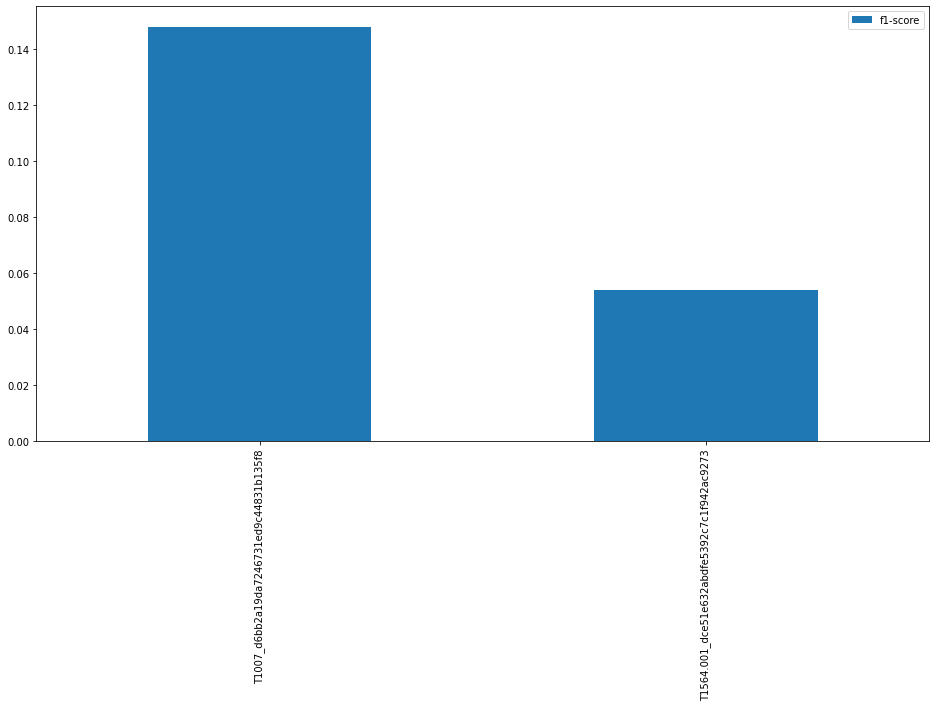

In [28]:
import matplotlib.pyplot as plt

# filtered_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize = (12,8))
filtered_report[['f1-score']].plot(kind='bar', figsize = (16,8))
plt.show()